In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import re
import nltk
from datetime import datetime
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
import emoji
from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
!pip install openpyxl

     |████████████████████████████████| 243 kB 1.2 MB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=f8e8f781d44d330f13ef632b8fb2b60fa8703df34001d3d8b776427974bb02bb
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


## Import Data

In [3]:
df_all = pd.read_excel('../input/5153-data/data_all.xlsx') 
df_all = df_all.dropna(subset=['review_content'])
print(df_all.shape)
df_all.head()

(27370, 9)


,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars
0,1,2021-02-04 21:57:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Pink,Gooood delivery thanks seller!! Box is kinda c...,NaN,k*****i,5
1,2,2021-02-17 00:28:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",NaN,w*****4,3
2,3,2021-02-10 14:21:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Fast delivery! First time buying, it’s all wel...",NaN,j*****g,4
3,4,2021-02-16 00:57:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Pink,Ordered for the 3rd time because the elastic b...,helloimhc21,NaN,5
4,5,2021-02-10 11:25:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Local shipping was quite fast. \n2nd purchase ...,NaN,h*****h,5


# Part 1: Proposed Method

## Process Negative Reviews
Select the 1-3 star reviews, remove the sub-sentences with positive sentiments, to serve as training data with negative sentiment label. 

In [4]:
df_neg=df_all[df_all.review_stars<4]
df_neg['review_stars']=0   # neg is 0, serve as y_label for training
print(df_neg.shape)
df_neg.head()

(794, 9)


,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars
1,2,2021-02-17 00:28:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",NaN,w*****4,0
11,12,2021-02-08 21:23:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Fast delivery. Box dented. Quality is thin. I ...,NaN,n*****4,0
12,13,2021-02-12 11:39:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Second purchase the mask.. so disappointed not...,NaN,s*****l,0
13,14,2021-02-16 16:38:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult White,Received within a few days. However it is not ...,NaN,h*****i,0
22,23,2021-01-09 17:46:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Took 3 days to arrived. Unresponsive and rejec...,NaN,i*****9,0


In [5]:
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos = nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    
    # Adjective tags - 'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags - 'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags - 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'

    # Noun tags - 'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl = WordNetLemmatizer()
    for word in words:
        pos = find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

In [6]:
def remove_pos(text):    
    """break text into sub-sentences, carry out sentiment analysis, then remove the subsentences with positive parts"""
    text=emoji.demojize(text) 
    text=text.lower()
    text=words_lemmatizer(text)
    text=re.sub(r"(\w)\1{2,}",r"\1", text)
    text=re.sub(r",",'. ',text)
    text=re.sub(r"\\n",'. ',text)
    text=re.sub(r"although",'. ',text)
    text=re.sub(r"but",'. ',text)
    text=re.sub(r"however",'. ',text)
    text=re.sub(r"so ",'. ',text)
    text=re.sub(r"though",'. ',text)
    text=re.sub(r"\.{3}",'. ',text)
    text=re.sub(r"\.{2}",'. ',text)
    sentence=sent_tokenize(text) #
    
    SIA = SentimentIntensityAnalyzer()
    new_sent = ["".join(sent) for sent in sentence if (SIA.polarity_scores(sent)['compound']<=0)] #remove the subsentences with positive parts
    
    if len(new_sent)==0:
        new_sent=np.nan
    return new_sent

In [7]:
df_neg['review_content_new']=df_neg['review_content'].apply(lambda x: remove_pos(x))
df_neg = df_neg.dropna(subset=['review_content_new'])
print(df_neg.shape)
df_neg.head()

(760, 10)


,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars,review_content_new
1,2,2021-02-17 00:28:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",NaN,w*****4,0,"[order on 6th ., rec 'd parcel on 10 feb at 11..."
11,12,2021-02-08 21:23:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Fast delivery. Box dented. Quality is thin. I ...,NaN,n*****4,0,"[fast delivery ., box dent ., quality be thin ..."
12,13,2021-02-12 11:39:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Second purchase the mask.. so disappointed not...,NaN,s*****l,0,"[second purchase the mask., ., disappointed no..."
13,14,2021-02-16 16:38:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult White,Received within a few days. However it is not ...,NaN,h*****i,0,"[receive within a few day ., ., it be not 3 pl..."
22,23,2021-01-09 17:46:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Took 3 days to arrived. Unresponsive and rejec...,NaN,i*****9,0,"[take 3 day to arrive ., unresponsive and reje..."


## Process Positive Reviews
Select the 5 star reviews, remove the sub-sentences with negative sentiments, to serve as training data with positive sentiment label. 

In [8]:
df_pos=df_all[df_all.review_stars==5].sample(n=800,random_state=5153)
df_pos['review_stars']=1           # pos is 1, serve as y_label for training
print(df_pos.shape)
df_pos.head()

(800, 9)


,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars
23337,23338,2020-11-17 13:41:00,ipoopedben,*NEW COLOUR* MICO DISPOSABLE FACE MASK (50pcs)...,"White (Stars),ADULT (17.5X9.5CM)",10 masks per packet for hygiene purposes. Boug...,totorosg,NaN,1
38969,38970,2020-11-27 11:30:00,undertaker4,MR.ING 3ply Mask Adult Medical Grade disposabl...,Adult White 50pc+Box,"Received the product after 1 week, product is ...",sq70izd8d3,NaN,1
34551,34552,2021-01-31 23:08:00,house7017.sg,[8Color Mask] Korea 4ply mask/ 3D MASK/HOT ITE...,MASK DA White 50PCS,The quality of the mask seems fine for the pri...,NaN,j*****k,1
3908,3909,2021-01-25 21:17:00,iptec_pte_ltd,Made in Singapore IPTEC High Quality Surgical ...,Surgical Masks,Received in good condition. Super fast deliver...,johnchen2020,NaN,1
8612,8613,2021-01-07 21:35:00,hdthealthcare,BYD Single-use Surgical Mask Japanese Version,Surgical Masks,"Nice, it is soft and no smell. 2nd time of pur...",NaN,h*****g,1


In [9]:
def remove_neg(text):
    """break text into sub-sentences, carry out sentiment analysis, then remove the subsentences with negative parts"""
    text=emoji.demojize(text) 
    text=text.lower()
    text=words_lemmatizer(text)
    text=re.sub(r",",'. ',text)
    text=re.sub(r"\\n",'. ',text)
    text=re.sub(r"although",'. ',text)
    text=re.sub(r"but",'. ',text)
    text=re.sub(r"however",'. ',text)
    text=re.sub(r"so ",'. ',text)
    text=re.sub(r"though",'. ',text)
    text=re.sub(r"\.{3}",'. ',text)
    text=re.sub(r"\.{2}",'. ',text)

    sentence=sent_tokenize(text)
    SIA = SentimentIntensityAnalyzer()
    new_sent = ["".join(sent) for sent in sentence if (SIA.polarity_scores(sent)['compound']>=0)] #remove the subsentences with negative parts
    if len(new_sent)==0:
        new_sent=np.nan
#     new_sent=[SIA.polarity_scores(sent) for sent in sentence ]
    return new_sent

In [10]:
df_pos['review_content_new']=df_pos['review_content'].apply(lambda x: remove_neg(x))
df_pos=df_pos.dropna(subset=['review_content_new'])
print(df_pos.shape)
df_pos.head()

(799, 10)


,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars,review_content_new
23337,23338,2020-11-17 13:41:00,ipoopedben,*NEW COLOUR* MICO DISPOSABLE FACE MASK (50pcs)...,"White (Stars),ADULT (17.5X9.5CM)",10 masks per packet for hygiene purposes. Boug...,totorosg,NaN,1,"[10 mask per packet for hygiene purpose ., bou..."
38969,38970,2020-11-27 11:30:00,undertaker4,MR.ING 3ply Mask Adult Medical Grade disposabl...,Adult White 50pc+Box,"Received the product after 1 week, product is ...",sq70izd8d3,NaN,1,"[receive the product after 1 week ., product b..."
34551,34552,2021-01-31 23:08:00,house7017.sg,[8Color Mask] Korea 4ply mask/ 3D MASK/HOT ITE...,MASK DA White 50PCS,The quality of the mask seems fine for the pri...,NaN,j*****k,1,[the quality of the mask seem fine for the pri...
3908,3909,2021-01-25 21:17:00,iptec_pte_ltd,Made in Singapore IPTEC High Quality Surgical ...,Surgical Masks,Received in good condition. Super fast deliver...,johnchen2020,NaN,1,"[receive in good condition ., super fast deliv..."
8612,8613,2021-01-07 21:35:00,hdthealthcare,BYD Single-use Surgical Mask Japanese Version,Surgical Masks,"Nice, it is soft and no smell. 2nd time of pur...",NaN,h*****g,1,"[nice ., 2nd time of purchase byd mask from htd]"


## Merge Negative and Positive dataframes to get train data

In [11]:
df_review=pd.concat([df_neg,df_pos]).sample(frac=1)
df_review['review_content_new']=df_review.review_content_new.astype('str')
print(df_review['review_content_new'].iloc[10])
print(df_review['review_content'].iloc[10])

['fast delivery !', 'good quality mask .']
Fast delivery! Good quality mask.


In [12]:
df_review['review_content_new'] #new sentences with positive/negative sub-sentences removed

2892                                              ['good']
20569    ['initially we .', 'it be split into 2 deliver...
841      ['i now i carefully read and order from shopee...
24390          ['super fast delivery and nicely packed .']
6123     ['mask be soft .', 'unfortunately front be fac...
                               ...                        
10434    ['fast delivery .', 'good price .', 'well pack...
32539                 ['love it .', 'fast delivery too .']
3908     ['receive in good condition .', 'super fast de...
16681                                            ['great']
23196    ['parcel be deliver with a4 white paper wrap a...
Name: review_content_new, Length: 1559, dtype: object

In [13]:
X_train,X_test,y_train,y_test=train_test_split(df_review.review_content_new,df_review.review_stars,test_size=0.1, stratify=df_review.review_stars, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1403,) (156,) (1403,) (156,)


In [14]:
vect = CountVectorizer()
clf = MultinomialNB()
pipe = make_pipeline(vect, clf)

In [15]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time
from sklearn.model_selection import StratifiedKFold

param_hyperopt= {
    'countvectorizer__min_df':        hp.choice('countvectorizer__min_df', np.arange(1, 6,1, dtype=int)), 
    'multinomialnb__alpha':           hp.uniform('multinomialnb__alpha', 0.0, 1.0)                                   
}


K_fold=StratifiedKFold(n_splits=5,shuffle=False)

In [16]:
def hyperopt(param_space, X_train, y_train):
    
    start = time()
    
    # defin the object function
    def objective_function(params):
        clf = pipe.set_params(**params) ### since pipeline object is not callable
        score = cross_val_score(clf, X_train, y_train, cv=K_fold,scoring='f1_macro').mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()

    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, # you can change other algorithms such as GP,
                      max_evals=5, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    
    clf_best = pipe.set_params(      
                    countvectorizer__min_df=int(best_param_values[0]),                   
                    multinomialnb__alpha=float(best_param_values[1]))

    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Time elapsed: ", time() - start)
   
    
    return clf_best,best_param

In [17]:
best_model,best_param = hyperopt(param_hyperopt, X_train, y_train)

100%|██████████| 5/5 [00:01<00:00,  4.86trial/s, best loss: -0.9049813917215503]

##### Results
Score best parameters:  0.9049813917215503
Best parameters:  {'countvectorizer__min_df': 2, 'multinomialnb__alpha': 0.7034400418549064}
Time elapsed:  1.037904977798462


In [18]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        76
           1       0.92      0.95      0.93        80

    accuracy                           0.93       156
   macro avg       0.93      0.93      0.93       156
weighted avg       0.93      0.93      0.93       156



## Prediction

In [19]:
df = df_all[df_all.review_stars<=4]
df.head()

,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars
1,2,2021-02-17 00:28:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",NaN,w*****4,3
2,3,2021-02-10 14:21:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Fast delivery! First time buying, it’s all wel...",NaN,j*****g,4
11,12,2021-02-08 21:23:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Fast delivery. Box dented. Quality is thin. I ...,NaN,n*****4,3
12,13,2021-02-12 11:39:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Second purchase the mask.. so disappointed not...,NaN,s*****l,2
13,14,2021-02-16 16:38:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult White,Received within a few days. However it is not ...,NaN,h*****i,3


In [20]:
def text_sent_token(text):
    """break text into sub-sentences and tokenize the"""
    text=emoji.demojize(text) 
    text=text.lower()
    text=words_lemmatizer(text)
    text=re.sub(r",",'. ',text)
    text=re.sub(r"\\n",'. ',text)
    text=re.sub(r"although",'. ',text)
    text=re.sub(r"but",'. ',text)
    text=re.sub(r"however",'. ',text)
    text=re.sub(r"so ",'. ',text)
    text=re.sub(r"though",'. ',text)
    text=re.sub(r"\.{3}",'. ',text)
    text=re.sub(r"\.{2}",'. ',text)

    sentence=sent_tokenize(text)
    return sentence

In [21]:
df['sentence']=df['review_content'].apply(lambda x: text_sent_token(x))
print(df.shape)
df.head()

(2072, 10)


,review_id,time,seller_name,product_name,product_variation,review_content,customer_name_full,customer_name_anonymous,review_stars,sentence
1,2,2021-02-17 00:28:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",NaN,w*****4,3,"[order on 6th ., rec 'd parcel on 10 feb at 11..."
2,3,2021-02-10 14:21:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,"Fast delivery! First time buying, it’s all wel...",NaN,j*****g,4,"[fast delivery !, first time buying ., it ’ s ..."
11,12,2021-02-08 21:23:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Fast delivery. Box dented. Quality is thin. I ...,NaN,n*****4,3,"[fast delivery ., box dent ., quality be thin ..."
12,13,2021-02-12 11:39:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult Black,Second purchase the mask.. so disappointed not...,NaN,s*****l,2,"[second purchase the mask., ., disappointed no..."
13,14,2021-02-16 16:38:00,ezlifesg,Local Ready Stock 3 PLY Disposable Face Masks ...,Adult White,Received within a few days. However it is not ...,NaN,h*****i,3,"[receive within a few day ., ., it be not 3 pl..."


In [22]:
df['review_content']

1        Ordered on 6th, rec'd parcel on 10 Feb at 11.3...
2        Fast delivery! First time buying, it’s all wel...
11       Fast delivery. Box dented. Quality is thin. I ...
12       Second purchase the mask.. so disappointed not...
13       Received within a few days. However it is not ...
                               ...                        
40614    The ear loop connecting to the mask is opposit...
40624                         The price is higher than q10
40626    Two out of 4 boxes are dented. Good thing that...
40631    Box came damaged but packing inside is fine. D...
40642    both mask quality were ok but the straps are v...
Name: review_content, Length: 2072, dtype: object

In [23]:
df['sentence']

1        [order on 6th ., rec 'd parcel on 10 feb at 11...
2        [fast delivery !, first time buying ., it ’ s ...
11       [fast delivery ., box dent ., quality be thin ...
12       [second purchase the mask., ., disappointed no...
13       [receive within a few day ., ., it be not 3 pl...
                               ...                        
40614    [the ear loop connect to the mask be opposite ...
40624                         [the price be high than q10]
40626    [two out of 4 box be dent ., good thing that t...
40631    [box come damage ., pack inside be fine ., del...
40642    [both mask quality be ok ., the strap be very ...
Name: sentence, Length: 2072, dtype: object

In [24]:
pred=[]
for sent in df.sentence:    
    pred.append(pipe.predict(sent))

In [25]:
results=df.sentence
results=results.reset_index()
print(results.shape)
results.head()

(2072, 2)


,index,sentence
0,1,"[order on 6th ., rec 'd parcel on 10 feb at 11..."
1,2,"[fast delivery !, first time buying ., it ’ s ..."
2,11,"[fast delivery ., box dent ., quality be thin ..."
3,12,"[second purchase the mask., ., disappointed no..."
4,13,"[receive within a few day ., ., it be not 3 pl..."


In [26]:
results['label']=pred
results['review_id']=list(df.review_id.values)
results=results.drop("index",axis=1)
results.head()

,sentence,label,review_id
0,"[order on 6th ., rec 'd parcel on 10 feb at 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",2
1,"[fast delivery !, first time buying ., it ’ s ...","[1, 1, 1, 0, 0, 1]",3
2,"[fast delivery ., box dent ., quality be thin ...","[1, 0, 0, 0]",12
3,"[second purchase the mask., ., disappointed no...","[1, 1, 0, 1, 1, 1]",13
4,"[receive within a few day ., ., it be not 3 pl...","[1, 1, 0, 0, 1, 0]",14


In [27]:
results.to_csv('pos_neg_results.csv')

In [28]:
results['new_neg_comments']=results.apply(lambda x: [x[0][i] for i in range(len(x[1])) if x[1][i]==0] ,axis=1)
# if all sentences in the comment are predicted positive, will be removed, and pred_label=0 (pred_label=1 will be selected) 
results['pred_label']=results['new_neg_comments'].apply(lambda x: 1 if len(x)!=0 else 0)
results.head()

,sentence,label,review_id,new_neg_comments,pred_label
0,"[order on 6th ., rec 'd parcel on 10 feb at 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",2,"[order on 6th ., rec 'd parcel on 10 feb at 11...",1
1,"[fast delivery !, first time buying ., it ’ s ...","[1, 1, 1, 0, 0, 1]",3,"[the material be not too thick ., which i pref...",1
2,"[fast delivery ., box dent ., quality be thin ...","[1, 0, 0, 0]",12,"[box dent ., quality be thin ., i try to wear ...",1
3,"[second purchase the mask., ., disappointed no...","[1, 1, 0, 1, 1, 1]",13,[disappointed not same a first i order .],1
4,"[receive within a few day ., ., it be not 3 pl...","[1, 1, 0, 0, 1, 0]",14,"[it be not 3 ply a described ., these be not r...",1


In [29]:
results.to_csv('1to4_stars_neg.csv', index=False)

## Evaluation after manual adjustment on negative/positive reviews separation

In [30]:
df_true=pd.read_excel('../input/5153-data/data_with_content_below4_negative.xlsx')
df_true=df_true[['review_content','review_id']]
results=results.merge(df_true, how='left',on='review_id')
results['true_label']=results.review_content.apply(lambda x: 0 if pd.isnull(x)==True else 1)
results.head()
#pred_label: 1 means including negative sentiment
#true_label: 1 means including negative sentiment (after manual confirmation)

,sentence,label,review_id,new_neg_comments,pred_label,review_content,true_label
0,"[order on 6th ., rec 'd parcel on 10 feb at 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",2,"[order on 6th ., rec 'd parcel on 10 feb at 11...",1,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",1
1,"[fast delivery !, first time buying ., it ’ s ...","[1, 1, 1, 0, 0, 1]",3,"[the material be not too thick ., which i pref...",1,NaN,0
2,"[fast delivery ., box dent ., quality be thin ...","[1, 0, 0, 0]",12,"[box dent ., quality be thin ., i try to wear ...",1,Fast delivery. Box dented. Quality is thin. I ...,1
3,"[second purchase the mask., ., disappointed no...","[1, 1, 0, 1, 1, 1]",13,[disappointed not same a first i order .],1,Second purchase the mask.. so disappointed not...,1
4,"[receive within a few day ., ., it be not 3 pl...","[1, 1, 0, 0, 1, 0]",14,"[it be not 3 ply a described ., these be not r...",1,Received within a few days. However it is not ...,1


In [31]:
results[results.review_id==12]

,sentence,label,review_id,new_neg_comments,pred_label,review_content,true_label
2,"[fast delivery ., box dent ., quality be thin ...","[1, 0, 0, 0]",12,"[box dent ., quality be thin ., i try to wear ...",1,Fast delivery. Box dented. Quality is thin. I ...,1


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(results.true_label, results.pred_label)

array([[ 375,  173],
       [  55, 1469]])

In [33]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report

precision = precision_score(results['pred_label'], results['true_label'])
recall = recall_score(results['pred_label'], results['true_label'])
accuracy = accuracy_score(results['pred_label'], results['true_label'])

print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(results['pred_label'], results['true_label']))

precision:  0.9639107611548556
recall:  0.8946406820950061
accuracy:  0.88996138996139
              precision    recall  f1-score   support

           0       0.68      0.87      0.77       430
           1       0.96      0.89      0.93      1642

    accuracy                           0.89      2072
   macro avg       0.82      0.88      0.85      2072
weighted avg       0.91      0.89      0.89      2072



# Part 2: Pure Sentiment Analysis
If any sub-sentence of a review is negative based on sentiment analysis, this review is classified as negative.

In [34]:
results.sentence[0]

['order on 6th .',
 "rec 'd parcel on 10 feb at 11.30pm .",
 'bot 4 box .',
 '1 box come empty .',
 'not sure why can pack till like that ?',
 'mail out empty box .',
 'msg seller completely no response at all .',
 'file for refund .',
 'tdy 16 feb deadline .',
 'shopee auto approve refund since no response fr seller .',
 'mask quality ok .']

In [35]:
sentiment_pred=[]
for sent_list in results.sentence:  
    pred_list = []
    for sent in sent_list:
        sentence=sent_tokenize(sent)
        SIA = SentimentIntensityAnalyzer()
        if SIA.polarity_scores(sent)['compound']<0:
            pred_list.append(1)
        else: 
            pred_list.append(0)
    sentiment_pred.append(pred_list)
        
results['pure_sentiment_label']=sentiment_pred
results.head()

,sentence,label,review_id,new_neg_comments,pred_label,review_content,true_label,pure_sentiment_label
0,"[order on 6th ., rec 'd parcel on 10 feb at 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",2,"[order on 6th ., rec 'd parcel on 10 feb at 11...",1,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",1,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]"
1,"[fast delivery !, first time buying ., it ’ s ...","[1, 1, 1, 0, 0, 1]",3,"[the material be not too thick ., which i pref...",1,NaN,0,"[0, 0, 0, 0, 0, 0]"
2,"[fast delivery ., box dent ., quality be thin ...","[1, 0, 0, 0]",12,"[box dent ., quality be thin ., i try to wear ...",1,Fast delivery. Box dented. Quality is thin. I ...,1,"[0, 0, 0, 1]"
3,"[second purchase the mask., ., disappointed no...","[1, 1, 0, 1, 1, 1]",13,[disappointed not same a first i order .],1,Second purchase the mask.. so disappointed not...,1,"[0, 0, 1, 0, 0, 0]"
4,"[receive within a few day ., ., it be not 3 pl...","[1, 1, 0, 0, 1, 0]",14,"[it be not 3 ply a described ., these be not r...",1,Received within a few days. However it is not ...,1,"[0, 0, 0, 0, 0, 0]"


In [36]:
results['sentiment_pred_label']=results['pure_sentiment_label'].apply(lambda x: 1 if np.sum(x)!=0 else 0)
results.head()

,sentence,label,review_id,new_neg_comments,pred_label,review_content,true_label,pure_sentiment_label,sentiment_pred_label
0,"[order on 6th ., rec 'd parcel on 10 feb at 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",2,"[order on 6th ., rec 'd parcel on 10 feb at 11...",1,"Ordered on 6th, rec'd parcel on 10 Feb at 11.3...",1,"[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]",1
1,"[fast delivery !, first time buying ., it ’ s ...","[1, 1, 1, 0, 0, 1]",3,"[the material be not too thick ., which i pref...",1,NaN,0,"[0, 0, 0, 0, 0, 0]",0
2,"[fast delivery ., box dent ., quality be thin ...","[1, 0, 0, 0]",12,"[box dent ., quality be thin ., i try to wear ...",1,Fast delivery. Box dented. Quality is thin. I ...,1,"[0, 0, 0, 1]",1
3,"[second purchase the mask., ., disappointed no...","[1, 1, 0, 1, 1, 1]",13,[disappointed not same a first i order .],1,Second purchase the mask.. so disappointed not...,1,"[0, 0, 1, 0, 0, 0]",1
4,"[receive within a few day ., ., it be not 3 pl...","[1, 1, 0, 0, 1, 0]",14,"[it be not 3 ply a described ., these be not r...",1,Received within a few days. However it is not ...,1,"[0, 0, 0, 0, 0, 0]",0


In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(results.true_label, results.sentiment_pred_label)

array([[528,  20],
       [759, 765]])

In [38]:
precision = precision_score(results.true_label, results.sentiment_pred_label)
recall = recall_score(results.true_label, results.sentiment_pred_label)
accuracy = accuracy_score(results.true_label, results.sentiment_pred_label)

print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print(classification_report(results.true_label, results.sentiment_pred_label))

precision:  0.9745222929936306
recall:  0.5019685039370079
accuracy:  0.624034749034749
              precision    recall  f1-score   support

           0       0.41      0.96      0.58       548
           1       0.97      0.50      0.66      1524

    accuracy                           0.62      2072
   macro avg       0.69      0.73      0.62      2072
weighted avg       0.83      0.62      0.64      2072



# Part 3: Results Summary

## Word Cloud

In [39]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

pos_stopwords = {'acceptable', 'comfortable', 'fast', 'fast delivery', 'fine', 'good', 'great', 'happy', 'like', 'love', 'luckily', 'nice', 'nicely', 'ok', 'okay', 
                 'pretty', 'recommend', 'recommended', 'thank', 'thanks', 'well'} 

neu_stopwords = {'abit', 'actually', 'already', 'although', 'also', 'better', 'bit', 'boxes', 'bought', 'buy', 'came', 'come', 'compared', 'condition', 'day', 
                 'delivered', 'due', 'enough', 'expected', 'even', 'face', 'feel', 'feels', 'find', 'first', 'fit', 'get', 'give', 'given', 'got', 'inside', 
                 'instead', 'it', 'item', 'items', 'hope', 'know','mask', 'masks', 'may', 'me', 'much', 'n', 'nan', 'need', 'next', 'one', 'order', 'ordered', 
                 'overall', 'pc', 'please', 'ply','purchase', 'purchased', 'put', 'quite', 'really', 'review', 's', 'see', 'seem', 'seems', 'seller', 'side', 
                 'slightly', 'star', 'stars', 'still', 'super','sure', 'there', 'though', 'took', 'tried', 'try', 'u', 'use', 'using', 'way', 'will', 'within', 
                 'would', 'yet'}

for word in pos_stopwords:
    stopwords = STOPWORDS.add(word)
    
for word in neu_stopwords:
    stopwords = STOPWORDS.add(word)

In [40]:
import string

def combine_text(df, column):
    text = ''
    for i, row in enumerate(df[column]):
        text += (' ' + row)
    text = ' '.join([w.lower().strip(string.punctuation) for w in text.split()])
    return text

def get_wordcloud(text):
    wordcloud = WordCloud(
        background_color="white", 
        width=1500,              
        height=960,              
        margin=10, 
        stopwords=stopwords
        ).generate(text)
    fig, ax = plt.subplots(figsize=(20, 12))    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

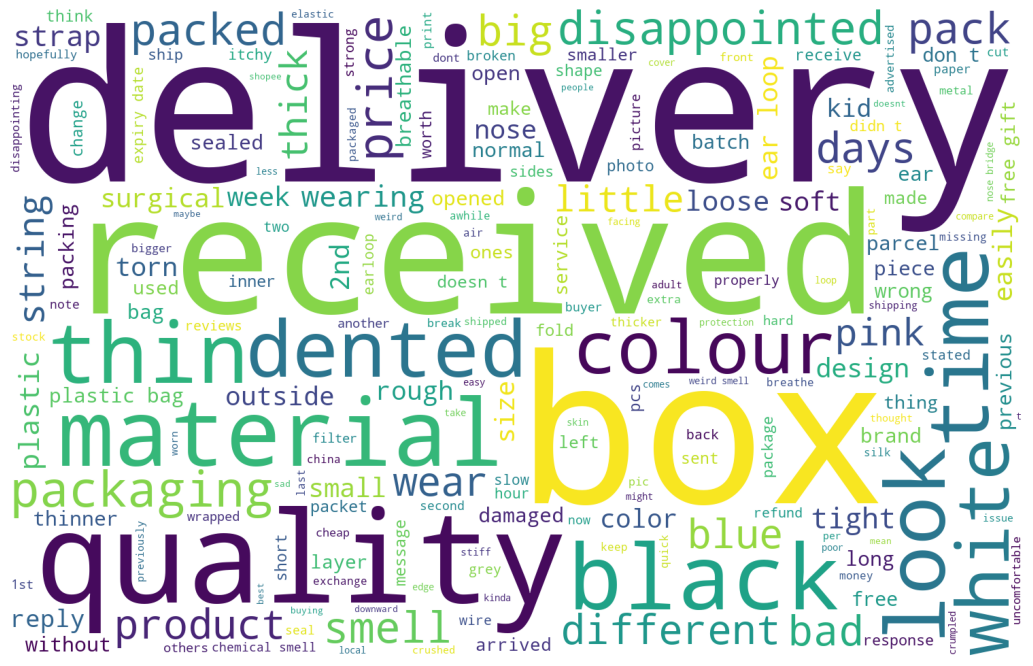

In [41]:
get_wordcloud(combine_text(df_true, 'review_content')) 

## LDA

In [42]:
from nltk.corpus import stopwords

def remove_stopwords(words, lang='english'):
    # Function to remove stop words
    lang_stopwords = stopwords.words(lang) 
    
    for word in pos_stopwords:
        lang_stopwords.append(word)
    
    for word in neu_stopwords:
        lang_stopwords.append(word)
        
    stopwords_removed = [w for w in words.split() if w.lower().strip(string.punctuation) not in lang_stopwords]
    return " ".join(stopwords_removed)

In [43]:
from sklearn import decomposition
from sklearn.feature_extraction.text import CountVectorizer

def compute_LDA(df, column):
    df['Text_Clean'] = df[column].apply(remove_stopwords)
    count_vect = CountVectorizer()
    xtrain_count = count_vect.fit_transform(df.Text_Clean)

    #train
    lda_model = decomposition.LatentDirichletAllocation(n_components=1, learning_method='online', max_iter=20)
    X_topics = lda_model.fit_transform(xtrain_count)
    topic_word = lda_model.components_
    vocab = count_vect.get_feature_names()
 
    #visualization
    n_top_words = 100
    topic_summaries = []
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        topic_summaries.append(' '.join(topic_words))
    print(topic_summaries)

In [44]:
compute_LDA(df_true, 'review_content')

['delivery box received quality smell material black time thin dented however packed packaging it plastic white disappointed price colour nose big days blue different bad looks ear wear pink product thick free bag little pack 10 size loose wearing tight surgical sealed soft small easily wrong torn 2nd look strap without previous rough string brand outside loop design batch damaged date strong long week opened reply thinner parcel packing color properly kids normal metal gift packs open wrapped breathable don used ones there service straps wire weird expiry medical 1st inner arrived pieces made thing another smaller note left doesn']


## Word Frequency

In [45]:
df['Text_Clean'] = df['review_content'].apply(remove_stopwords)
text = [' '.join(list(df['Text_Clean']))]
#text = [" ".join(list(df['Text_Clean']))]
#text = ' '.join([sen for sen in df['Text_Clean'])
count_vect = CountVectorizer()
xtrain_count = count_vect.fit_transform(text)

In [46]:
word_freq=pd.DataFrame()
word_freq['word']=count_vect.get_feature_names()
word_freq['frequency']=xtrain_count.toarray()[0]
#word_freq['frequency']=word_freq['frequency'].astype('int64')
word_freq=word_freq.sort_values('frequency', ascending=False)
word_freq.head(50)

,word,frequency
703,delivery,556
1951,received,491
1903,quality,416
385,box,355
1494,material,166
2477,time,162
2211,smell,152
1696,packed,144
367,black,140
1836,price,127
